# Importing library

In [27]:
import os
import torch
from PIL import Image
import opendatasets as od
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Data Setting

In [28]:
batch_size = 4

## Monet dataset

In [29]:
transform =transforms.Compose([transforms.ToTensor()])

In [30]:
monet_dataset_folderurl=r'gan-getting-started\monet_jpg'

In [31]:
monet_tensor= []
for file in os.listdir(monet_dataset_folderurl):
    image_path = os.path.join(monet_dataset_folderurl, file)
    image = Image.open(image_path)
    image = transform(image)  # Assuming transform is a torchvision transform
    monet_tensor.append(image)

In [32]:
Monet_dl=DataLoader(monet_tensor, batch_size, shuffle=True, num_workers=2, pin_memory=False )

## Photos Dataset

In [33]:
photo_dataset_folderurl=r'gan-getting-started\photo_jpg'

In [34]:
photos_tensor=[]
for file in os.listdir(photo_dataset_folderurl):
    image_path = os.path.join(photo_dataset_folderurl, file)
    image = Image.open(image_path)
    image = transform(image)  # Assuming transform is a torchvision transform
    photos_tensor.append(image)

In [35]:
photos_dl=DataLoader(photos_tensor, batch_size, shuffle=True, num_workers=2, pin_memory=False )

# Model

## Style transfer model

In [80]:
class StyleTransfer(nn.Module):
    def __init__(self):
        super(StyleTransfer, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # shape: (batch_size, 32, 128, 128)
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # shape: (batch_size, 64, 64, 64)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # shape: (batch_size, 128, 32, 32)
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # shape: (batch_size, 64, 64, 64)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # shape: (batch_size, 32, 128, 128)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),    # shape: (batch_size, 3, 256, 256)
            nn.Sigmoid()  # Using Sigmoid to get the output in the range [0, 1]
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [81]:
model = StyleTransfer()

## Discriminator 

In [82]:
discriminator= nn.Sequential(
                                nn.Conv2d(3,32, kernel_size= 4, stride= 2, padding= 2), #shape b_s, 32 , 128,128 
                                                                                                                
                                nn.Conv2d(32,64, kernel_size= 4, stride= 2, padding= 2), #shape b_s, 64 , 64,64
                                     
                                nn.Conv2d(64,32, kernel_size= 4, stride= 2, padding= 2), #shape b_s, 32 , 32,32 
                                      
                                nn.Conv2d(32,16, kernel_size= 4, stride= 2, padding= 2), #shape b_s, 16 ,16 ,16 
                                      
                                nn.Conv2d(16,8,kernel_size= 4, stride= 2, padding= 2),  #shape b_s, 8,8,8
                                       
                                nn.Conv2d(8,4,kernel_size= 4, stride= 2, padding= 2),   #shape b_s, 4,4,4
                                       
                                nn.Conv2d(4,2,kernel_size= 4, stride= 2, padding= 2 ),  #shape b_s, 2,2,2
                                       
                                nn.Conv2d(2,1,kernel_size= 4, stride= 2, padding= 2 ),  #shape b_s, 1,1,1
                                    nn.Conv2d(1,1,kernel_size= 2, stride= 1, padding= 0 ),  #shape b_s, 1,1,1 
                                nn.Flatten(), nn.Sigmoid()
                                    )

In [83]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=2),  # shape: (batch_size, 32, 128, 128)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=2),  # shape: (batch_size, 64, 64, 64)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(64, 32, kernel_size=4, stride=2, padding=2),  # shape: (batch_size, 32, 32, 32)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(32, 16, kernel_size=4, stride=2, padding=2),  # shape: (batch_size, 16, 16, 16)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(16, 8, kernel_size=4, stride=2, padding=2),   # shape: (batch_size, 8, 8, 8)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(8, 4, kernel_size=4, stride=2, padding=2),    # shape: (batch_size, 4, 4, 4)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(4, 2, kernel_size=4, stride=2, padding=2),    # shape: (batch_size, 2, 2, 2)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(2, 1, kernel_size=4, stride=2, padding=2),    # shape: (batch_size, 1, 1, 1)
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(1, 1, kernel_size=2, stride=1, padding=0),    # shape: (batch_size, 1, 1, 1)
    nn.Flatten(),
    nn.Sigmoid()
)


In [84]:
x =discriminator(monet_tensor[0].unsqueeze(0))

In [85]:
def x():
 axs[0].imshow(image_np)
 axs[0].set_title('Original Image')
 axs[0].axis('off')

# Plot the model output image
 axs[1].imshow(model_output_image)
 axs[1].set_title('Model Output')
 axs[1].axis('off')

In [86]:
k=0
def save_progress(k, save=False):
 image_np = photos_tensor[3].cpu().detach().numpy().transpose(1, 2, 0)

 model_output_image= model(photos_tensor[3]).cpu().detach().numpy().transpose(1, 2, 0)

# Create a figure and a grid of subplots
 fig, axs = plt.subplots(1, 2, figsize=(10, 5))


# Plot the original image


# Adjust the layout to make room for titles

 #plt.tight_layout()
 if save:
  fig.savefig(r'Output\output_images__{i}.png'.format(i=k))
 return k


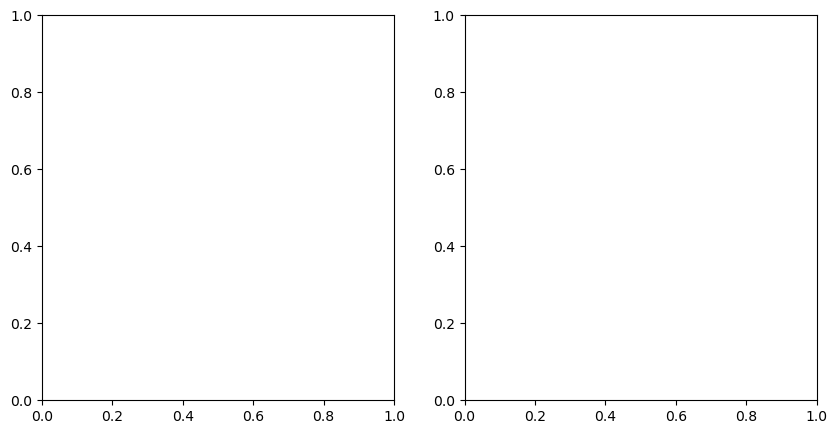

In [87]:
k= save_progress(k+1, save= False )

# Train discriminator

In [88]:
import torch.nn.functional as F

In [89]:
def train_discriminator(real_img,fake_img ,opt_d):
    #clear discriminator grad
    opt_d.zero_grad()

    #passreal imageto discriminaor
    real_pred=discriminator(real_img)
    real_target = torch.ones(real_img.size(0), 1)
    real_loss = F.cross_entropy(real_pred, real_target)
    fake_score = torch.mean(real_pred).item()
    real_score = torch.mean(real_pred).item()


    #pass fake  image through discriminator
    fake_pred = discriminator(fake_img)
    fake_target = torch.zeros(fake_img.size(0), 1)
    fake_loss =  F.binary_cross_entropy(fake_pred, fake_target)
    fake_score = torch.mean(fake_pred).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score



In [99]:
def train_generator(opt_g, real_img):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    fake_images = model(real_img)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.zeros_like(preds)  # Use zeros as targets for fake images
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()


In [100]:
from tqdm.notebook import tqdm

# Training model

In [101]:
def fit(epochs, lr):
    k=1
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
#    opt_g = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for real_images , fake_images in tqdm(zip(Monet_dl, photos_dl)):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, fake_images,opt_d)
            loss_g  = train_generator(fake_images, opt_g)
            # Train generator
            
   #     for fake_images in tqdm(photos_dl):

      #      loss_g  = model(fake_images, opt_d)

        # Record losses & scores
     #   losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        #print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        #    epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        print("Epoch [{}/{}], loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
           epoch+1, epochs,  loss_d, real_score, fake_score))

        # Save generated images
        k= save_progress(k+1, save= True )
        

    return losses_g, losses_d, real_scores, fake_scores

In [102]:
lr = 0.0002
epochs = 25

In [103]:
history = fit(epochs, lr)

0it [00:00, ?it/s]

AttributeError: 'Tensor' object has no attribute 'zero_grad'